# Appendices

Source code to replicate key results from the appendix

In [1]:
# Libraries and imports
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
from utils import helpers
import torchvision
from PIL import Image
from torchvision.models import resnet50
import timeit
import torch
from spectral_sobol.torch_explainer import WaveletSobol


2023-04-17 14:58:38.787576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 14:58:39.565737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Number of designs

The number of designs corresponds to the number of deviations around the mean sequence. It is used to compute the variance of the Sobol indices. However, a high number of designs leads to an increased computational burden. 

We study the effect of the number of designs on the estimation of the Sobol indices

In [2]:
# Set up 

device = 'cuda:2'
model = resnet50(pretrained = True).to(device)

classes = {
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

image_names = list(classes.keys())

images = [Image.open('../assets/{}'.format(img_name)) for img_name in image_names]

# transforms
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])
 
x = torch.stack(
    [preprocessing(img) for img in images]
)

y = np.array([classes[img_name] for img_name in image_names])

# loop with a varying number of designs

variants = []
times = []

for i in range(5):

    print('Testing with i = {}'.format(i))
    wavelet = WaveletSobol(model, grid_size = 28, nb_design = 2 ** (i+1), batch_size = 128)

    start = timeit.default_timer()
    variants.append(wavelet(x,y))
    stop = timeit.default_timer()

    times.append(stop - start)

Testing with i = 0
Testing with i = 1
Testing with i = 2
Testing with i = 3
Testing with i = 4


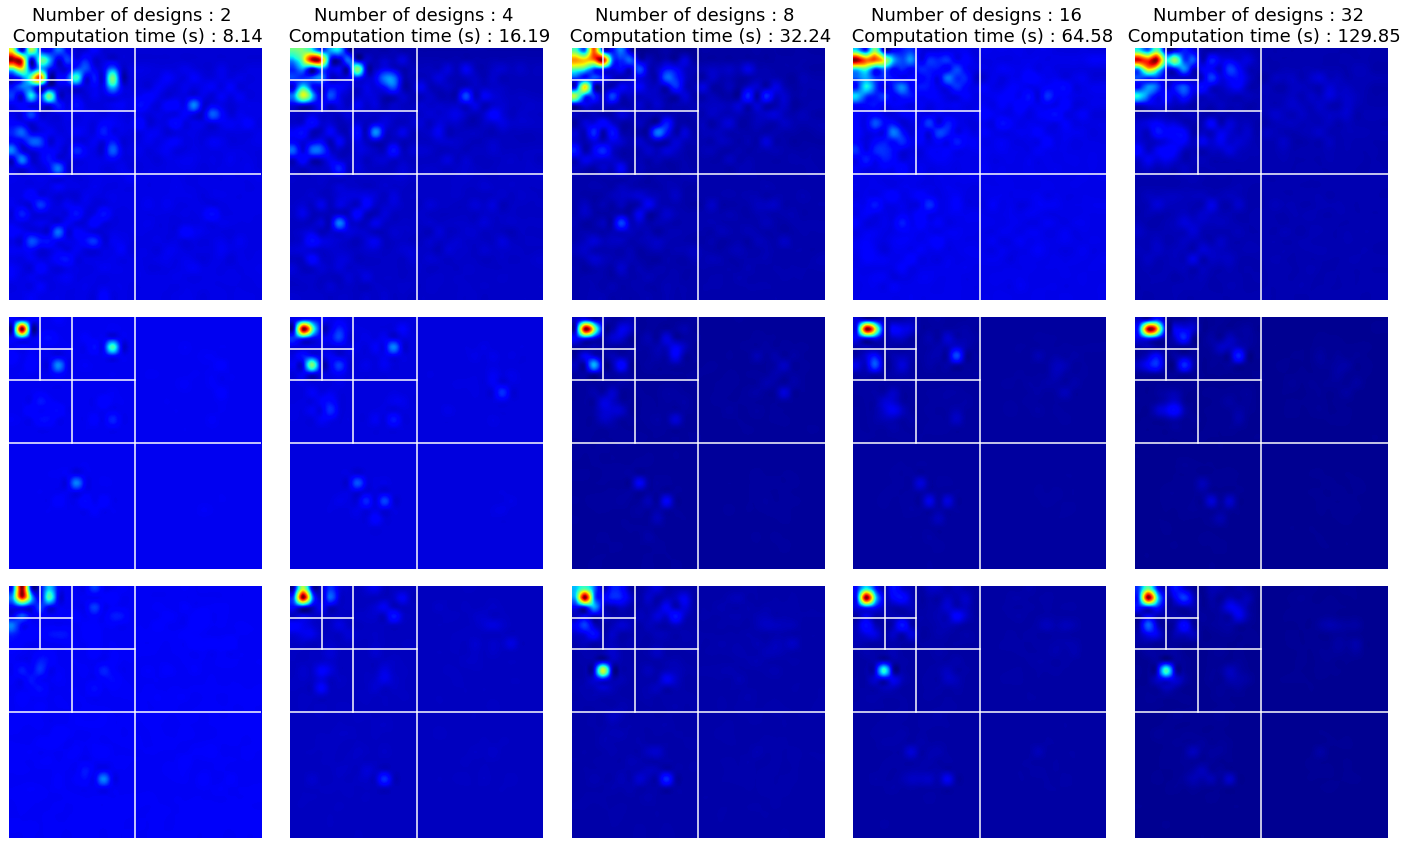

In [13]:
# plots
plt.rcParams.update({'font.size': 15})


size = 224 # input size
levels = 3 # number of levels in the wavelet decomposition

indices = [3,4,7]

n_rows = len(indices)
n_cols = len(variants)

fig, ax = plt.subplots(n_rows, n_cols, figsize = (4 * n_cols, 4 * n_rows))

for j in range(n_cols):

    variant = variants[j] # retrieve the list of wcams
    
    for k, index in enumerate(indices) : # only plot some samples

        nb_design = 2 ** (j+1)

        title = 'Number of designs : {} \n Computation time (s) : {:0.2f}'.format(nb_design, times[j] / 10)
        
        ax[0,j].set_title(title)
        ax[k,j].imshow(variant[index], cmap = 'jet')
        ax[k,j].axis('off')

        helpers.add_lines(size, levels, ax[k,j])

fig.tight_layout()


plt.savefig('../figs/nb_design.pdf')
fig.tight_layout()
plt.show()

## Grid size and number of levels

Evaluate the effect of the grid size and the number of levels on the shape of the WCAM